In [1]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

from copy import deepcopy

In [2]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [3]:
print(tf.__version__)
print(torch.__version__)

2.20.0
2.5.0


In [4]:
# Set random seeds for reproducibility
tf.random.set_seed(42)

torch.manual_seed(42)

np.random.seed(42)

In [5]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.5.0


In [6]:
train_df = pd.read_csv('Data/train.csv', index_col=0)
val_df = pd.read_csv('Data/val.csv', index_col=0)
test_df = pd.read_csv('Data/test.csv', index_col=0)

print(train_df.shape, val_df.shape, test_df.shape)

(12285, 5) (3510, 5) (1756, 5)


In [7]:
train_df

,temp,clouds_all,traffic_volume,day_sin,day_cos
0,0.760019,0.00,0.758755,0.066987,0.250000
1,0.738174,0.00,0.560765,0.017037,0.370590
2,0.698884,0.00,0.463513,0.000000,0.500000
3,0.668238,0.00,0.370029,0.017037,0.629410
4,0.643093,0.00,0.325101,0.066987,0.750000
...,...,...,...,...,...
12280,0.422599,0.90,0.599972,0.933013,0.250000
12281,0.421656,0.75,0.561881,0.853553,0.146447
12282,0.436272,0.90,0.567881,0.750000,0.066987
12283,0.439415,0.75,0.644482,0.629410,0.017037


In [8]:
# TF
class DataWindowtf():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [9]:
# TF
def compile_and_fittf(model, window, patience=3, max_epochs=50): #  The function takes a model and a window of data from the DataWindow class. The patience is the number of epochs after which the model should stop training if the validation loss does not improve; max_epochs sets a maximum number of epochs to train the model.
    early_stopping = EarlyStopping(monitor='val_loss', # The validation loss is tracked to determine if we should apply early stopping or not.
                                   patience=patience, # Early stopping occurs if 3 consecutive epochs do not decrease the validation loss, as set by the patience parameter.
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(), #  The MSE is used as the loss function.
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()]) # The MAE is used as an error metric. This is how we compare the performance of our models. A lower MAE means a better model.
    
    history = model.fit(window.train, # The model is fit on the training set.
                       epochs=max_epochs, # The model can train for at most 50 epochs, as set by the max_epochs parameter.
                       validation_data=window.val, # We use the validation set to calculate the validation loss.
                       callbacks=[early_stopping]) # early_stopping is passed as a callback. If the validation loss does not decrease after 3 consecutive epochs, the model stops training. This avoids overfitting.
    
    return history

In [10]:
# Pytortch
class TimeSeriesDataset(Dataset):
    def __init__(self, data, sequence_length, target_columns=None , stride=1):
        self.data = torch.FloatTensor(data.values if hasattr(data, 'values') else data)
        self.sequence_length = sequence_length
        self.target_columns = target_columns
        self.stride = stride
        
        # Calculate valid starting indices
        self.indices = list(range(0, len(self.data) - sequence_length + 1, stride))
        
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        start_idx = self.indices[idx]
        sequence = self.data[start_idx:start_idx + self.sequence_length]
        return sequence

class DataWindowpt():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None, batch_size=32):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns # Name of the column that we wish to predict
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}  # Create a dictionary with the name and index of the label column. This will be used for plotting.
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)} # Create a dictionary with the name and index of each column. This will be used to separate the features from the target variable.
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.batch_size = batch_size
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width) # The slice function returns a slice object that specifies how to slice a sequence. In this case, it says that the input slice starts at 0 and ends when we reach the input_width.
        self.input_indices = np.arange(self.total_window_size)[self.input_slice] # Assign indices to the inputs. These are useful for plotting.
        
        self.label_start = self.total_window_size - self.label_width # Get the index at which the label starts. In this case, it is the total window size minus the width of the label.
        self.labels_slice = slice(self.label_start, None) # The same steps that were applied for the inputs are applied for labels.
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :] # Slice the window to get the inputs using the input_slice defined in __init__.
        labels = features[:, self.labels_slice, :] # Slice the window to get the labels using the labels_slice defined in __init__.
        
        if self.label_columns is not None: # if we have more than one target, we stack the labels.
            label_indices = [self.column_indices[name] for name in self.label_columns]
            labels = labels[:, :, label_indices]
            
        return inputs, labels
    
    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index].detach().numpy(),
                     label='Inputs', marker='.', zorder=-10) # Plot the inputs. They will appear as a continuous blue line with dots.

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index].detach().numpy(),
                        edgecolors='k', marker='s', label='Labels', c='green', s=64) # Plot the labels or actual values. They will appear as green squares.
            
            if model is not None:
                with torch.no_grad():
                    predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index].detach().numpy(),
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64) #  Plot the predictions. They will appear as red crosses.

            if n == 0:
                plt.legend()

        plt.xlabel('Time (h)')
    
    def make_dataset(self, data):
        dataset = TimeSeriesDataset(data, self.total_window_size, stride=1)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        
        # Create a mapped dataloader
        def mapped_dataloader():
            for batch in dataloader:
                yield self.split_to_inputs_labels(batch)
        
        return mapped_dataloader()
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [11]:
# Evaluation function pytorch
def evaluate_model(model, dataloader, verbose=0):
    model.eval()
    criterion = nn.MSELoss()
    total_loss = 0
    total_mae = 0
    num_batches = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            predictions = model(inputs)
            loss = criterion(predictions, labels)
            mae = torch.mean(torch.abs(predictions - labels))
            
            total_loss += loss.item()
            total_mae += mae.item()
            num_batches += 1
    
    avg_loss = total_loss / num_batches
    avg_mae = total_mae / num_batches
    
    if verbose > 0:
        print(f'Loss: {avg_loss:.4f} - MAE: {avg_mae:.4f}')
    
    return avg_loss, avg_mae

In [12]:
# PT
# Early stopping class
class EarlyStoppingpt:
    def __init__(self, patience=3, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1

        if self.counter >= self.patience:
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False

    def save_checkpoint(self, model):
        self.best_weights = deepcopy(model.state_dict())

In [13]:
# PT
# Training function
def compile_and_fitpt(model, window, patience=3, max_epochs=50, learning_rate=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    early_stopping = EarlyStoppingpt(patience=patience)
    
    train_losses = []
    val_losses = []
    train_maes = []
    val_maes = []
    
    for epoch in range(max_epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        total_train_mae = 0
        train_batches = 0
        
        for inputs, labels in window.train:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            total_train_mae += torch.mean(torch.abs(outputs - labels)).item()
            train_batches += 1
        
        avg_train_loss = total_train_loss / train_batches
        avg_train_mae = total_train_mae / train_batches
        
        # Validation phase
        model.eval()
        total_val_loss = 0
        total_val_mae = 0
        val_batches = 0
        
        with torch.no_grad():
            for inputs, labels in window.val:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                total_val_loss += loss.item()
                total_val_mae += torch.mean(torch.abs(outputs - labels)).item()
                val_batches += 1
        
        avg_val_loss = total_val_loss / val_batches
        avg_val_mae = total_val_mae / val_batches
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_maes.append(avg_train_mae)
        val_maes.append(avg_val_mae)
        
        print(f'Epoch {epoch+1}/{max_epochs} - '
              f'loss: {avg_train_loss:.4f} - mae: {avg_train_mae:.4f} - '
              f'val_loss: {avg_val_loss:.4f} - val_mae: {avg_val_mae:.4f}')
        
        if early_stopping(avg_val_loss, model):
            print(f'Early stopping at epoch {epoch+1}')
            break
    
    # Return history-like object
    history = {
        'loss': train_losses,
        'val_loss': val_losses,
        'mae': train_maes,
        'val_mae': val_maes
    }
    
    return history

# Autoregressive LSTM

In [14]:
# TF
multi_window = DataWindowtf(input_width=24, label_width=24, shift=24, label_columns=['traffic_volume'])

In [15]:
# Values obtained from 15

ms_mae_val = [0.352, 0.347, 0.088, 0.078, 0.070, 0.078, 0.069]
ms_mae_test = [0.347, 0.341, 0.076, 0.064, 0.058, 0.063, 0.055]

In [16]:
# TF
class AutoRegressivetf(Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = LSTMCell(units) # The LSTMCell layer is a lower-level layer than the LSTM layer. It allows us to access more granular information, such as state and predictions, which we can then manipulate to feed an output back into the model as an input.
        self.lstm_rnn = RNN(self.lstm_cell, return_state=True)
        self.dense = Dense(train_df.shape[1])
        
    def warmup(self, inputs): #  a way to capture the first prediction
        x, *state = self.lstm_rnn(inputs) # Pass the inputs through the LSTM layer. The output is sent to the Dense layer.
        prediction = self.dense(x) # Get a prediction from the Dense layer.
                
        return prediction, state
    
    def call(self, inputs, training=None):
        predictions = [] #  Initialize an empty list to collect all the predictions.
        prediction, state = self.warmup(inputs) # The first prediction is obtained from the warmup function.
        
        predictions.append(prediction) # Place the first prediction in the list of predictions.
        
        for n in range(1, self.out_steps):
            x = prediction # The prediction becomes an input for the next one.
            x, state = self.lstm_cell(x, states=state, training=training)
            
            prediction = self.dense(x) # Generate a new prediction using the previous one as an input.
            predictions.append(prediction)
        
        predictions = tf.stack(predictions) # Stack all the predictions. At this point, we have a shape (time, batch, features). It must be changed to (batch, time, features).
        predictions = tf.transpose(predictions, [1, 0, 2]) # Use transpose to get the needed shape of (batch, time, features).
        
        return predictions

In [17]:
# TF
AR_LSTM = AutoRegressivetf(units=32, out_steps=24)

history = compile_and_fittf(AR_LSTM, multi_window)

ms_val_performance = {}
ms_performance = {}

ms_val_performance['AR - LSTM-TF'] = AR_LSTM.evaluate(multi_window.val)
ms_performance['AR - LSTM-TF'] = AR_LSTM.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0468 - mean_absolute_error: 0.1654 - val_loss: 0.0212 - val_mean_absolute_error: 0.1056
Epoch 2/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0171 - mean_absolute_error: 0.0931 - val_loss: 0.0168 - val_mean_absolute_error: 0.0913
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0152 - mean_absolute_error: 0.0854 - val_loss: 0.0160 - val_mean_absolute_error: 0.0886
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0145 - mean_absolute_error: 0.0823 - val_loss: 0.0156 - val_mean_absolute_error: 0.0866
Epoch 5/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0140 - mean_absolute_error: 0.0801 - val_loss: 0.0157 - val_mean_absolute_error: 0.0853
Epoch 6/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0138 - mean_absolute_error: 0.0795 - val_loss: 0.0148 - val_mean_absolute_error: 0.0804
Epoch 7/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0134 - mean_absolute_error: 0.0778 - 

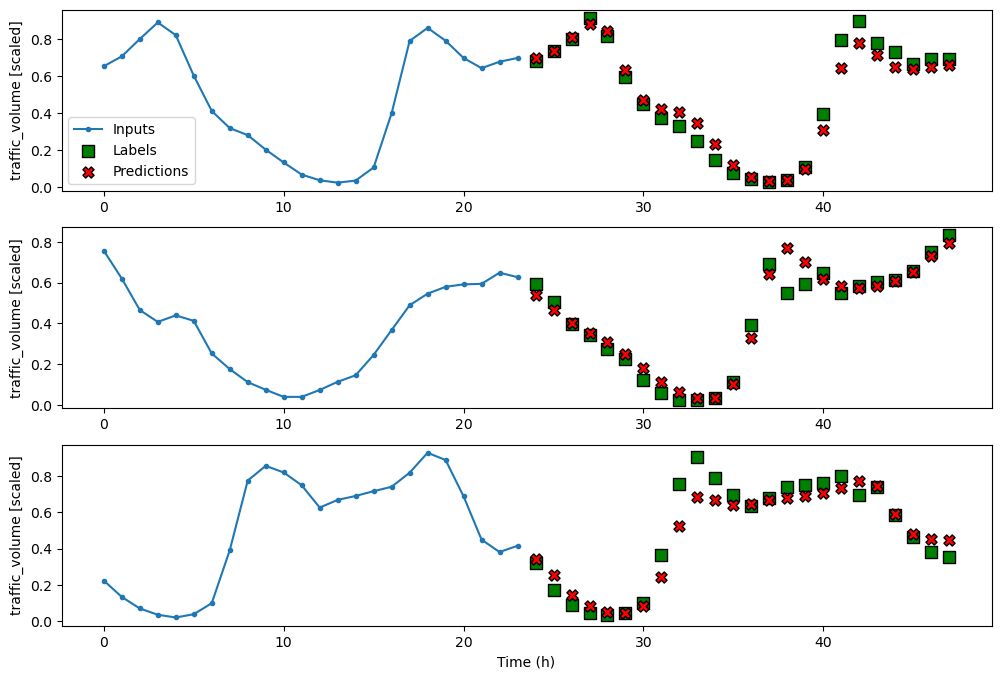

In [18]:
multi_window.plot(AR_LSTM)

In [19]:
# PT
multi_window = DataWindowpt(input_width=24, label_width=24, shift=24, label_columns=['traffic_volume'])

In [20]:
# PT
class AutoRegressivept(nn.Module):
    def __init__(self, input_size, units, out_steps):
        super(AutoRegressivept, self).__init__()
        self.out_steps = out_steps
        self.units = units
        self.input_size = input_size
        
        self.lstm_cell = nn.LSTMCell(input_size, units)
        self.dense = nn.Linear(units, input_size)
        
    def warmup(self, inputs):
        # inputs shape: (batch_size, seq_len, input_size)
        batch_size = inputs.size(0)
        h = torch.zeros(batch_size, self.units).to(inputs.device)
        c = torch.zeros(batch_size, self.units).to(inputs.device)
        
        # Process the input sequence
        for i in range(inputs.size(1)):
            h, c = self.lstm_cell(inputs[:, i, :], (h, c))
        
        # Generate first prediction
        prediction = self.dense(h)
        
        return prediction, (h, c)
    
    def forward(self, inputs):
        predictions = []
        prediction, state = self.warmup(inputs)
        
        predictions.append(prediction.unsqueeze(1))
        
        for n in range(1, self.out_steps):
            h, c = self.lstm_cell(prediction, state)
            state = (h, c)
            prediction = self.dense(h)
            predictions.append(prediction.unsqueeze(1))
        
        # Stack predictions: (batch_size, out_steps, input_size)
        predictions = torch.cat(predictions, dim=1)
        
        return predictions

In [21]:
# PT
AR_LSTM = AutoRegressivept(input_size=train_df.shape[1], units=32, out_steps=24)

history = compile_and_fitpt(AR_LSTM, multi_window)

ms_val_performance['AR - LSTM-PT'] = evaluate_model(AR_LSTM, multi_window.val)
ms_performance['AR - LSTM-PT'] = evaluate_model(AR_LSTM, multi_window.test)

C:\Users\ASUS\miniconda3\envs\DataVis\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 24, 1])) that is different to the input size (torch.Size([32, 24, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\ASUS\miniconda3\envs\DataVis\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([14, 24, 1])) that is different to the input size (torch.Size([14, 24, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\ASUS\miniconda3\envs\DataVis\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([7, 24, 1])) that is different to the input size (torch.Size([7, 24, 5])). This will likely lead to incorrect results due to 

Epoch 1/50 - loss: 0.0487 - mae: 0.1702 - val_loss: 0.0212 - val_mae: 0.1055
Epoch 2/50 - loss: 0.0175 - mae: 0.0942 - val_loss: 0.0183 - val_mae: 0.0971
Epoch 3/50 - loss: 0.0162 - mae: 0.0890 - val_loss: 0.0174 - val_mae: 0.0940
Epoch 4/50 - loss: 0.0150 - mae: 0.0843 - val_loss: 0.0153 - val_mae: 0.0837
Epoch 5/50 - loss: 0.0137 - mae: 0.0793 - val_loss: 0.0144 - val_mae: 0.0798
Epoch 6/50 - loss: 0.0131 - mae: 0.0767 - val_loss: 0.0147 - val_mae: 0.0778
Epoch 7/50 - loss: 0.0124 - mae: 0.0741 - val_loss: 0.0138 - val_mae: 0.0799
Epoch 8/50 - loss: 0.0122 - mae: 0.0732 - val_loss: 0.0130 - val_mae: 0.0729
Epoch 9/50 - loss: 0.0114 - mae: 0.0704 - val_loss: 0.0138 - val_mae: 0.0794
Epoch 10/50 - loss: 0.0113 - mae: 0.0700 - val_loss: 0.0116 - val_mae: 0.0685
Epoch 11/50 - loss: 0.0109 - mae: 0.0682 - val_loss: 0.0120 - val_mae: 0.0724
Epoch 12/50 - loss: 0.0106 - mae: 0.0675 - val_loss: 0.0124 - val_mae: 0.0695
Epoch 13/50 - loss: 0.0104 - mae: 0.0665 - val_loss: 0.0111 - val_mae: 0.

C:\Users\ASUS\miniconda3\envs\DataVis\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([13, 24, 1])) that is different to the input size (torch.Size([13, 24, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


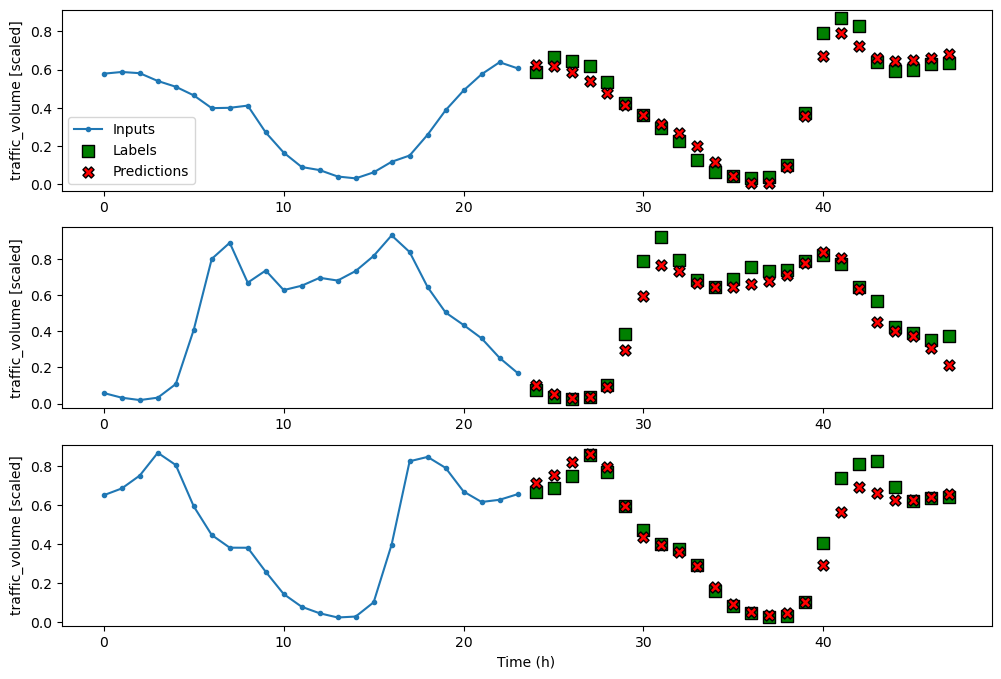

In [22]:
multi_window.plot(AR_LSTM)

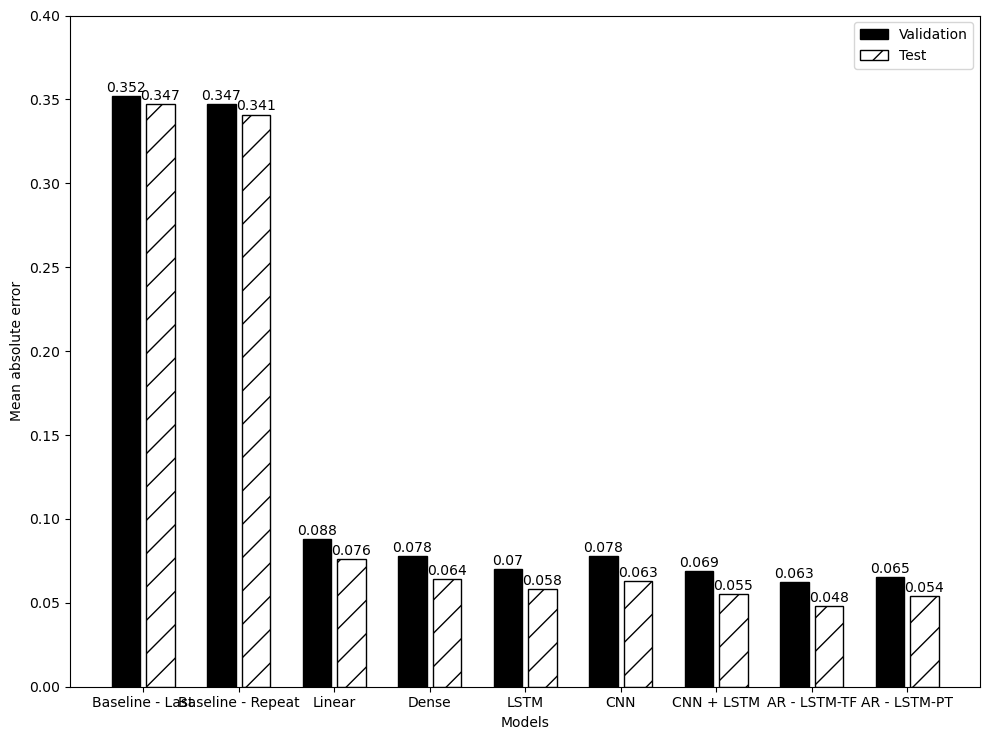

In [23]:
ms_mae_val.append(ms_val_performance['AR - LSTM-TF'][1])
ms_mae_test.append(ms_performance['AR - LSTM-TF'][1])
ms_mae_val.append(ms_val_performance['AR - LSTM-PT'][1])
ms_mae_test.append(ms_performance['AR - LSTM-PT'][1])

x = np.arange(9)

labels = ['Baseline - Last', 'Baseline - Repeat', 'Linear', 'Dense', 'LSTM', 'CNN', 'CNN + LSTM', 'AR - LSTM-TF', 'AR - LSTM-PT']

fig, ax = plt.subplots()
ax.bar(x - 0.18, ms_mae_val, width=0.3, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.18, ms_mae_test, width=0.3, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.18, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.18, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

# Excercises

In [25]:
train_df = pd.read_csv('Data/ex_train.csv')
val_df = pd.read_csv('Data/ex_val.csv')
test_df = pd.read_csv('Data/ex_test.csv')

print(train_df.shape, val_df.shape, test_df.shape)

(13239, 12) (3783, 12) (1892, 12)


In [26]:
train_df

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,WSPM,day_sin,day_cos
0,0.128492,0.146789,0.165192,0.340278,0.191919,0.000000,0.212230,0.614679,0.296721,0.062500,0.853553,0.853553
1,0.149721,0.179409,0.179941,0.343750,0.202020,0.000000,0.194245,0.559633,0.344262,0.062500,0.933013,0.750000
2,0.154190,0.216106,0.168142,0.340278,0.222222,0.000000,0.176259,0.522936,0.318033,0.035714,0.982963,0.629410
3,0.148603,0.158002,0.185841,0.361111,0.292929,0.000000,0.176259,0.522936,0.370492,0.035714,1.000000,0.500000
4,0.144134,0.163099,0.159292,0.364583,0.292929,0.000000,0.194245,0.486239,0.301639,0.098214,0.982963,0.370590
...,...,...,...,...,...,...,...,...,...,...,...,...
13234,0.130726,0.119266,0.008850,0.135417,0.121212,0.109264,0.776978,0.383486,0.921311,0.160714,0.500000,0.000000
13235,0.124022,0.113150,0.020649,0.131944,0.121212,0.175772,0.802158,0.381651,0.921311,0.089286,0.370590,0.017037
13236,0.129609,0.118247,0.026549,0.128472,0.131313,0.239905,0.812950,0.377982,0.913115,0.142857,0.250000,0.066987
13237,0.135196,0.123344,0.032448,0.121528,0.131313,0.344418,0.843525,0.376147,0.913115,0.133929,0.146447,0.146447


In [27]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='NO2', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [28]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

## Multi-step model

In [29]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['NO2'])

In [30]:
class AutoRegressive(Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = LSTMCell(units)
        self.lstm_rnn = RNN(self.lstm_cell, return_state=True)
        self.dense = Dense(train_df.shape[1])
        
    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)
        prediction = self.dense(x)
                
        return prediction, state
    
    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)
        
        predictions.append(prediction)
        
        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x, states=state, training=training)
            
            prediction = self.dense(x)
            predictions.append(prediction)
        
        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])
        
        return predictions

In [31]:
AR_LSTM = AutoRegressive(units=32, out_steps=24)

history = compile_and_fit(AR_LSTM, multi_window)

ms_val_performance = {}
ms_performance = {}

ms_val_performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.val)
ms_performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.test, verbose=0)

Epoch 1/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0135 - mean_absolute_error: 0.0880 - val_loss: 0.0084 - val_mean_absolute_error: 0.0690
Epoch 2/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0106 - mean_absolute_error: 0.0783 - val_loss: 0.0084 - val_mean_absolute_error: 0.0683
Epoch 3/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0098 - mean_absolute_error: 0.0751 - val_loss: 0.0082 - val_mean_absolute_error: 0.0670
Epoch 4/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0094 - mean_absolute_error: 0.0732 - val_loss: 0.0076 - val_mean_absolute_error: 0.0637
Epoch 5/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0091 - mean_absolute_error: 0.0718 - val_loss: 0.0078 - val_mean_absolute_error: 0.0640
Epoch 6/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0090 - mean_absolute_error: 0.0713 - val_loss: 0.0073 - val_mean_absolute_error: 0.0627
Epoch 7/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0087 - mean_absolute_error: 0.06

In [32]:
# Values obtained from 15

ms_mae_val = [0.282, 0.282, 0.070, 0.071, 0.069, 0.069, 0.069]
ms_mae_test = [0.243, 0.244, 0.115, 0.114, 0.114, 0.111, 0.112]

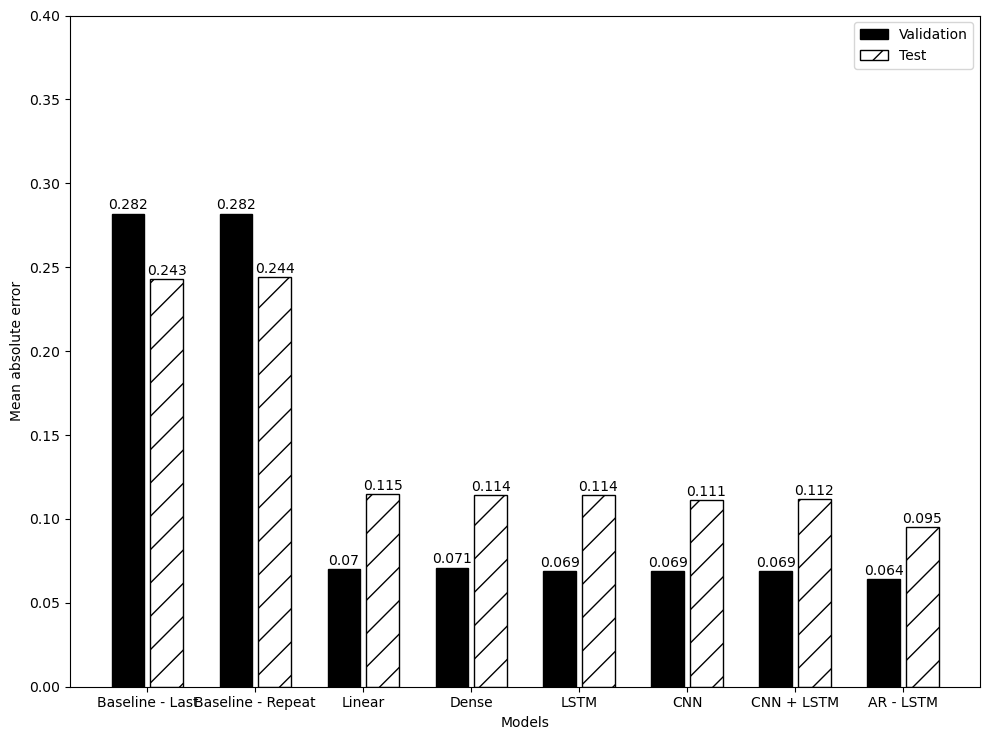

In [33]:
ms_mae_val.append(ms_val_performance['AR - LSTM'][1])
ms_mae_test.append(ms_performance['AR - LSTM'][1])

x = np.arange(8)

labels = ['Baseline - Last', 'Baseline - Repeat', 'Linear', 'Dense', 'LSTM', 'CNN', 'CNN + LSTM', 'AR - LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.18, ms_mae_val, width=0.3, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.18, ms_mae_test, width=0.3, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.18, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.18, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

In [34]:
# Summary
# The autoregressive architecture in deep learning has given birth to state-of-the-art
# models, such as WaveNet and DeepAR.

# An autoregressive deep learning model generates a sequence of predictions,
# but each prediction is fed back into the model as an input.
    
# A caveat regarding autoregressive deep learning models is that errors accumulate
# as the length of the sequence increases. Therefore, an early bad prediction
# can have a large effect on a late prediction.